In [4]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

%ls

Images/                Resources/
README.md              climate_starter.ipynb


In [15]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [16]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [17]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [19]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


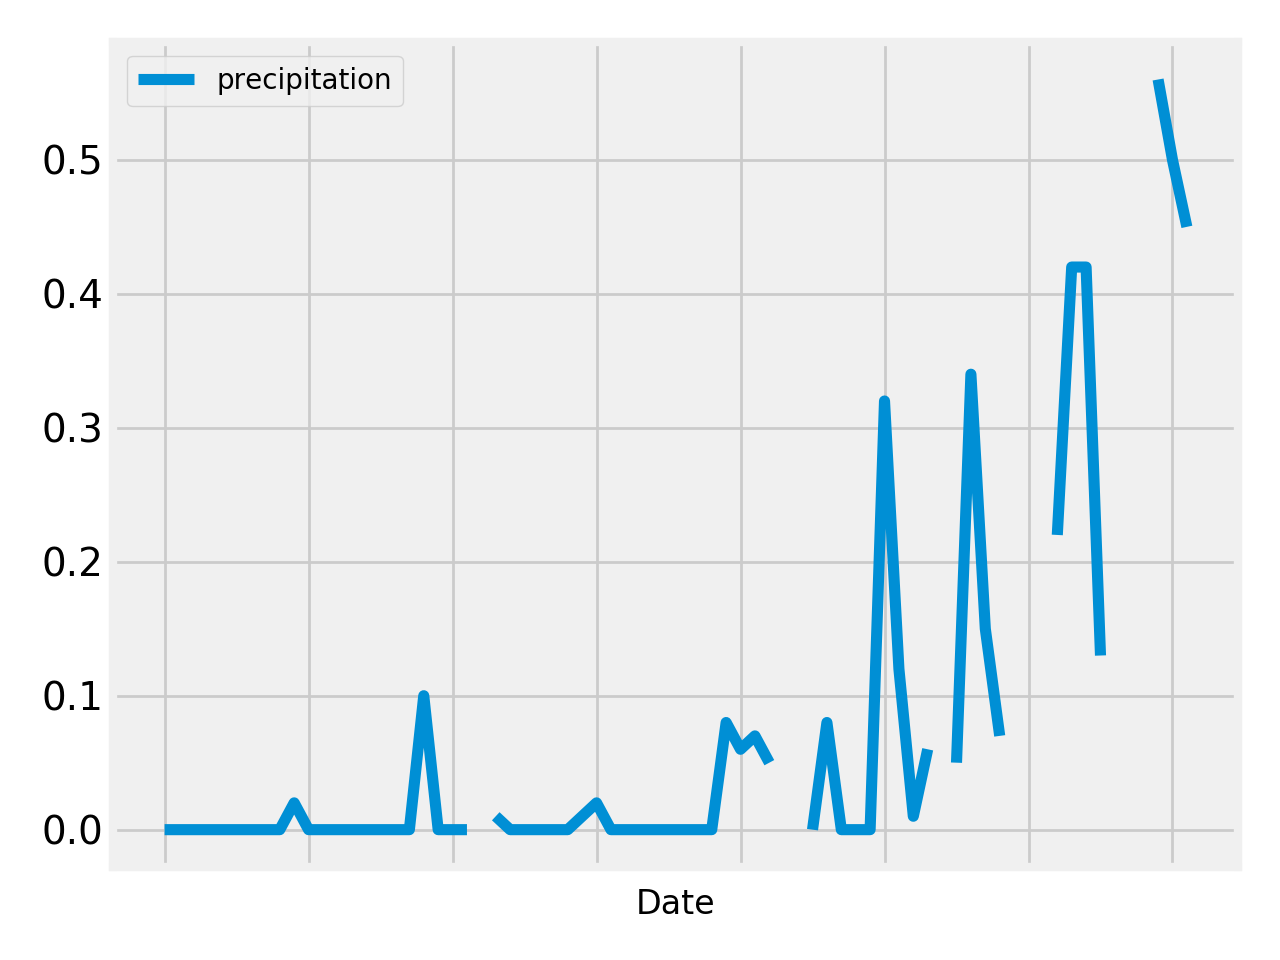

In [51]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today

previous_year = dt.date.today() - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

data_precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > previous_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

date_precipitation_df = pd.DataFrame(data_precipitation, columns= ["Date", "Precipitation"])
date_precipitation_df.set_index(date_precipitation_df["Date"], inplace=True) # inplace=True to create new object

# Sort the dataframe by date

date_precipitation_df.sort_values(["Date"])
date_precipitation_df

# Use Pandas Plotting with Matplotlib to plot the data

date_precipitation_df.plot("Date", "Precipitation")

# Rotate the xticks for the dates
plt.xlabel("Date", fontsize=12)
plt.legend(['precipitation'], fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()


In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data

date_precipitation_df.describe()

,Precipitation
count,64.000000
mean,0.071094
std,0.137392
min,0.000000
25%,0.000000
50%,0.000000
75%,0.072500
max,0.560000


In [39]:
# How many stations are available in this dataset?

data_stations = session.query(func.count(Station.station)).all()
data_stations

[(9)]

In [44]:
# What are the most active stations?
# List the stations and the counts in descending order.

most_precipitation = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_precipitation

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [46]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_temps = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
station_temps

[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


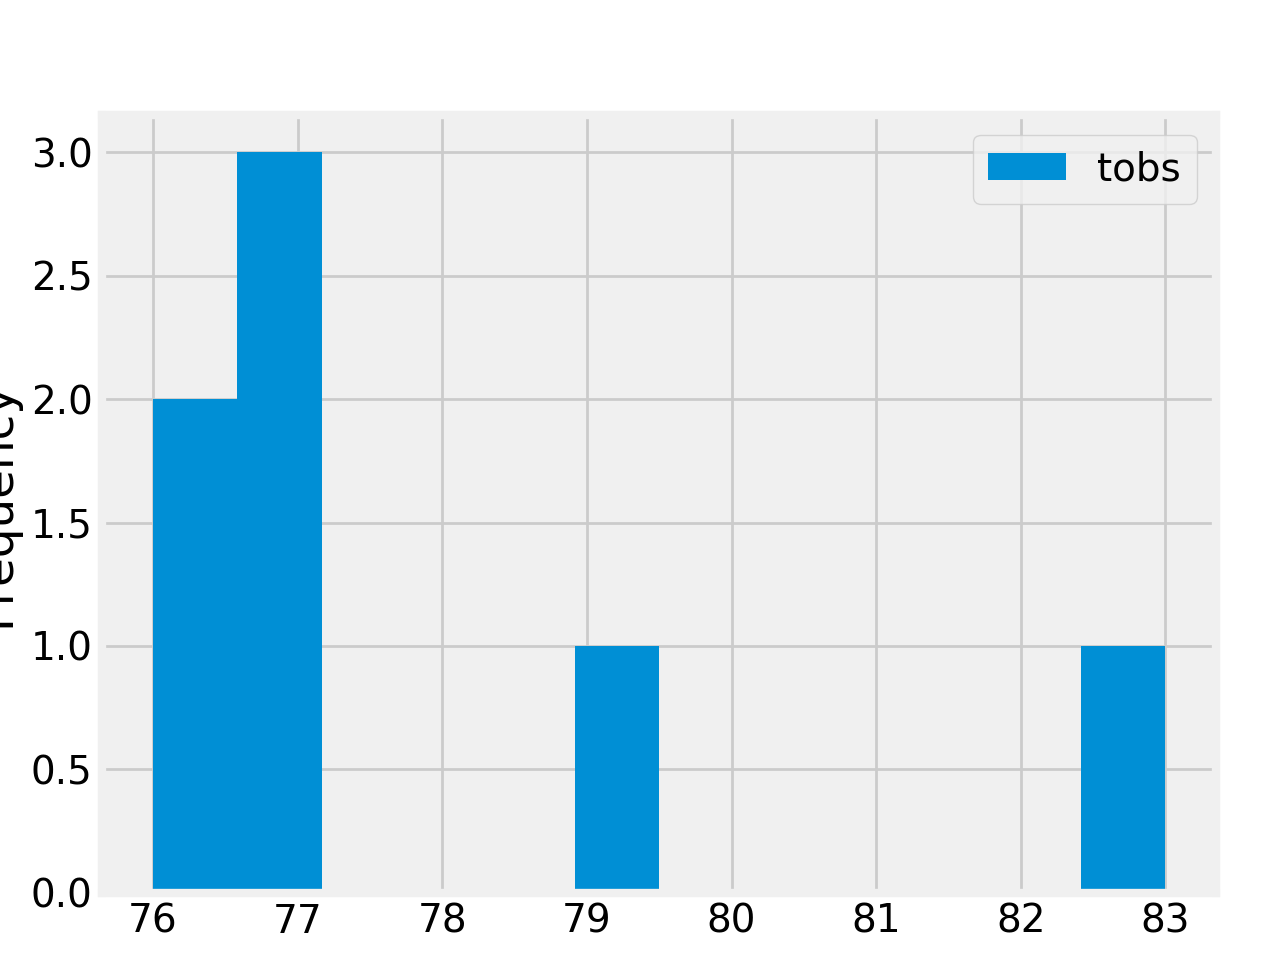

In [48]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_year = session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').filter(Measurement.date > previous_year).all()
last_year_df = pd.DataFrame(last_year, columns= ["tobs"])
last_year_df.plot.hist("tobs", bins = 12)

In [49]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [50]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2016-07-15', '2016-07-22')
temps

[(71.0, 77.41666666666667, 82.0)]

<IPython.core.display.Javascript object>


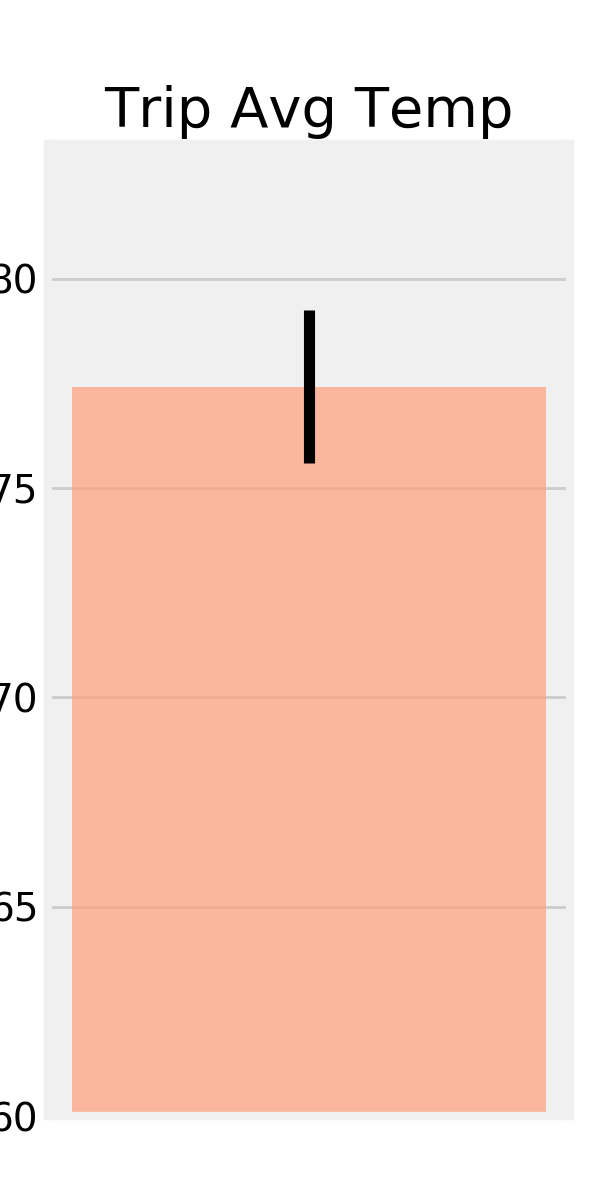

In [54]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lower = temps[0][1] - temps[0][0]
upper = temps[0][2] - temps[0][1]

plt.figure(figsize=(3,6))
plt.bar(0, temps[0][1], yerr=[upper-lower], color='lightsalmon', alpha=0.7)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')
plt.ylim(60)

plt.show()


In [63]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def total_rainfall(start_date, end_date):
    return session.query(Measurement.station, 
                         Measurement.prcp,
                         Station.latitude,
                         Station.longitude,
                         Station.elevation).\
                            group_by(Measurement.station).\
                            join(Station, Measurement.station == Station.station).\
                            filter(Measurement.date >= start_date).\
                            filter(Measurement.date <= end_date).\
                            order_by(Measurement.prcp.desc()).all()

total_rainfall('2016-07-15', '2016-07-22')


[('USC00519281', 0.13, 21.45167, -157.84888999999998, 32.9),
 ('USC00516128', 0.08, 21.3331, -157.8025, 152.4),
 ('USC00513117', 0.06, 21.4234, -157.8015, 14.6),
 ('USC00519523', 0.06, 21.33556, -157.71139, 19.5),
 ('USC00519397', 0.02, 21.2716, -157.8168, 3.0),
 ('USC00514830', 0.0, 21.5213, -157.8374, 7.0),
 ('USC00517948', None, 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


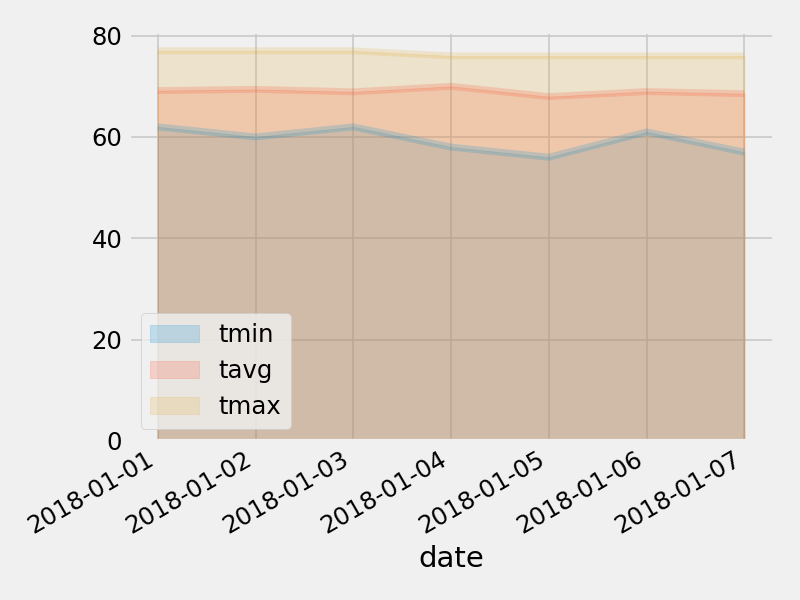

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
